# DATA 200 – Applied Statistical Analysis
## Week 4: Statistical Model Selection and Hypothesis Development
**Team Fintech** | Saugat Ojha · Rakesh Kumar Sah · Naitik Shrestha

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', font_scale=1.05)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 5)

BLUE = '#2E86AB'
RED  = '#E84855'

---
## 2. Load Dataset

In [2]:
df = pd.read_csv(r'C:\Users\admin\Desktop\project-team-x\bank.csv')
df['deposit_bin'] = (df['deposit'] == 'yes').astype(int)
print(f'Shape: {df.shape}')
df.head()

Shape: (11162, 18)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_bin
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,1


---
## 3. Encoding Categorical Variables

In [3]:
df_encoded = df.copy()
le = LabelEncoder()

cat_cols = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.drop(columns=['deposit'], inplace=True)
print('Encoding complete.')
df_encoded.head()

Encoding complete.


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit_bin
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


---
## 4. Feature Selection – Point Biserial Correlation

In [4]:
features = [c for c in df_encoded.columns if c != 'deposit_bin']
correlations = {}

for col in features:
    corr, pval = stats.pointbiserialr(df_encoded[col], df_encoded['deposit_bin'])
    correlations[col] = {'correlation': round(corr, 4), 'p_value': round(pval, 4)}

corr_df = pd.DataFrame(correlations).T
corr_df['abs_corr'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)
corr_df['significant'] = corr_df['p_value'] < 0.05
print(corr_df.to_string())

           correlation  p_value  abs_corr  significant
duration        0.4519   0.0000    0.4519         True
contact        -0.2498   0.0000    0.2498         True
housing        -0.2039   0.0000    0.2039         True
pdays           0.1516   0.0000    0.1516         True
previous        0.1399   0.0000    0.1399         True
campaign       -0.1281   0.0000    0.1281         True
poutcome       -0.1224   0.0000    0.1224         True
loan           -0.1106   0.0000    0.1106         True
education       0.0959   0.0000    0.0959         True
balance         0.0811   0.0000    0.0811         True
marital         0.0676   0.0000    0.0676         True
job             0.0634   0.0000    0.0634         True
day            -0.0563   0.0000    0.0563         True
default        -0.0407   0.0000    0.0407         True
month          -0.0371   0.0001    0.0371         True
age             0.0349   0.0002    0.0349         True


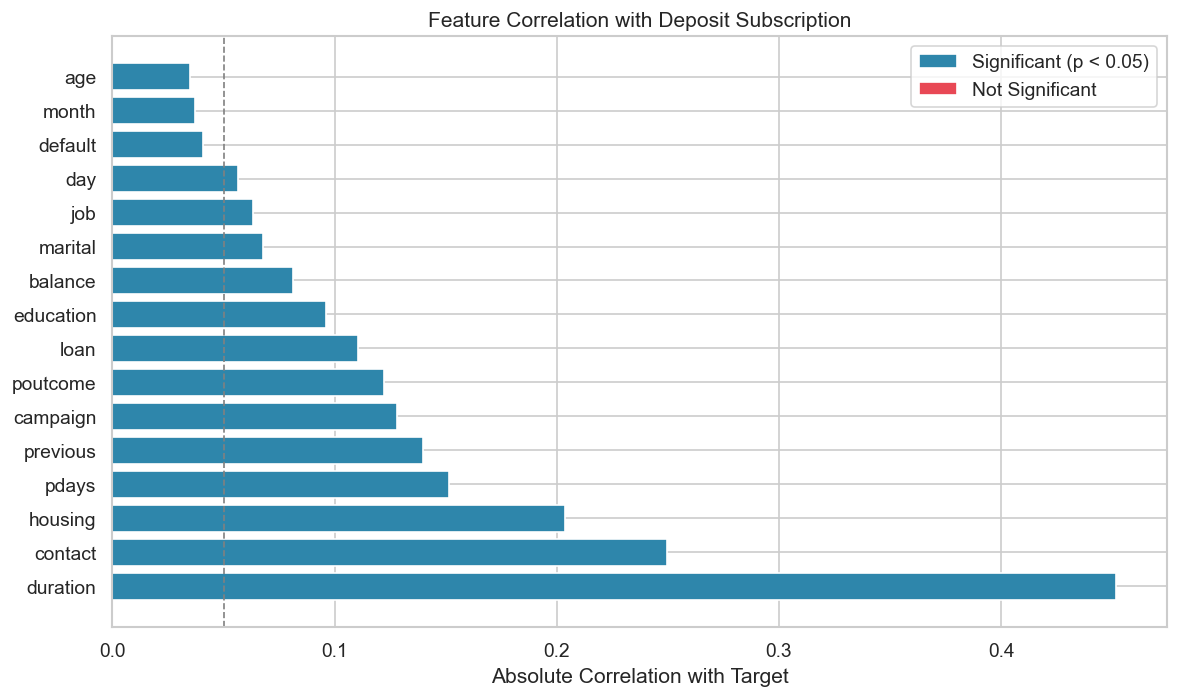

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = [BLUE if v else RED for v in corr_df['significant']]
ax.barh(corr_df.index, corr_df['abs_corr'], color=colors, edgecolor='white')
ax.set_xlabel('Absolute Correlation with Target')
ax.set_title('Feature Correlation with Deposit Subscription')
ax.axvline(0.05, color='gray', linestyle='--', linewidth=1)
legend_elements = [
    Patch(facecolor=BLUE, label='Significant (p < 0.05)'),
    Patch(facecolor=RED, label='Not Significant')
]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

---
## 5. Feature Selection – Chi-Square Test

In [6]:
X = df_encoded[features]
y = df_encoded['deposit_bin']

X_non_neg = X.copy()
for col in X_non_neg.columns:
    if X_non_neg[col].min() < 0:
        X_non_neg[col] = X_non_neg[col] - X_non_neg[col].min()

chi2_scores, chi2_pvals = chi2(X_non_neg, y)
chi2_df = pd.DataFrame({
    'feature': features,
    'chi2_score': chi2_scores.round(3),
    'p_value': chi2_pvals.round(4)
}).sort_values('chi2_score', ascending=False)

chi2_df['significant'] = chi2_df['p_value'] < 0.05
print(chi2_df.to_string(index=False))

  feature  chi2_score  p_value  significant
 duration  738362.340      0.0         True
  balance   91244.977      0.0         True
    pdays   57973.457      0.0         True
 previous    1377.693      0.0         True
  contact     953.667      0.0         True
 campaign     540.844      0.0         True
  housing     244.474      0.0         True
      day     160.355      0.0         True
     loan     118.635      0.0         True
      job     103.961      0.0         True
 poutcome      67.849      0.0         True
      age      46.796      0.0         True
education      44.909      0.0         True
    month      28.774      0.0         True
  default      18.194      0.0         True
  marital      16.646      0.0         True


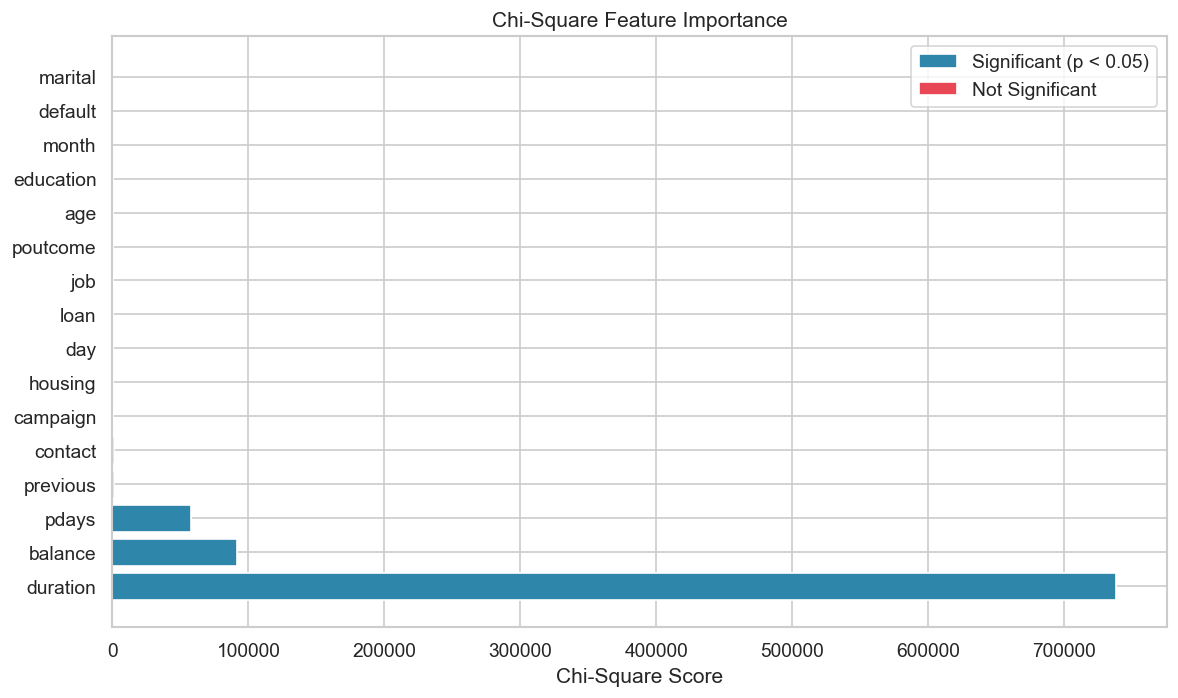

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = [BLUE if v else RED for v in chi2_df['significant']]
ax.barh(chi2_df['feature'], chi2_df['chi2_score'], color=colors, edgecolor='white')
ax.set_xlabel('Chi-Square Score')
ax.set_title('Chi-Square Feature Importance')
legend_elements = [
    Patch(facecolor=BLUE, label='Significant (p < 0.05)'),
    Patch(facecolor=RED, label='Not Significant')
]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

---
## 6. Feature Selection – Recursive Feature Elimination (RFE)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=lr, n_features_to_select=8)
rfe.fit(X_scaled, y)

rfe_df = pd.DataFrame({
    'feature': features,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
}).sort_values('ranking')

print(rfe_df.to_string(index=False))

  feature  selected  ranking
education      True        1
     loan      True        1
  housing      True        1
 previous      True        1
 campaign      True        1
    pdays      True        1
 duration      True        1
  contact      True        1
 poutcome     False        2
  balance     False        3
    month     False        4
  marital     False        5
      age     False        6
      day     False        7
  default     False        8
      job     False        9


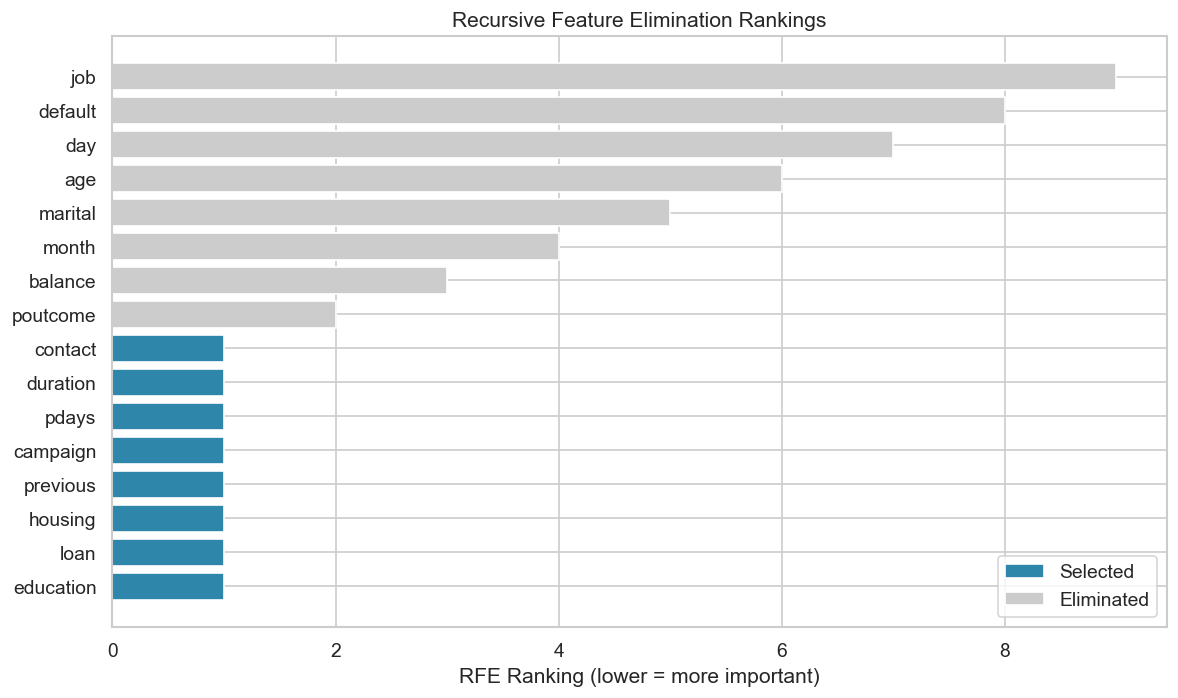

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = [BLUE if s else '#CCCCCC' for s in rfe_df['selected']]
ax.barh(rfe_df['feature'], rfe_df['ranking'], color=colors, edgecolor='white')
ax.set_xlabel('RFE Ranking (lower = more important)')
ax.set_title('Recursive Feature Elimination Rankings')
legend_elements = [
    Patch(facecolor=BLUE, label='Selected'),
    Patch(facecolor='#CCCCCC', label='Eliminated')
]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

---
## 7. Selected Features Summary

In [10]:
selected_features = list(rfe_df[rfe_df['selected'] == True]['feature'])
print('Selected features for Logistic Regression:')
for f in selected_features:
    print(f'  {f}')

Selected features for Logistic Regression:
  education
  loan
  housing
  previous
  campaign
  pdays
  duration
  contact


---
## 8. Model Justification

In [11]:
justification_df = pd.DataFrame({
    'Criterion': [
        'Target Variable Type',
        'Interpretability',
        'Dataset Size',
        'Multicollinearity',
        'Literature Support',
        'Output'
    ],
    'Justification': [
        'Binary outcome (yes/no) — directly suited for Logistic Regression',
        'Coefficients are interpretable as log-odds, meaningful for stakeholders',
        '11,162 records provides sufficient data for stable LR estimation',
        'Low multicollinearity among features confirmed in Week 3 EDA',
        'Jiang (2018) confirmed LR outperforms other models on this dataset',
        'Produces probability scores useful for campaign targeting decisions'
    ]
})

justification_df

,Criterion,Justification
0,Target Variable Type,Binary outcome (yes/no) — directly suited for ...
1,Interpretability,"Coefficients are interpretable as log-odds, me..."
2,Dataset Size,"11,162 records provides sufficient data for st..."
3,Multicollinearity,Low multicollinearity among features confirmed...
4,Literature Support,Jiang (2018) confirmed LR outperforms other mo...
5,Output,Produces probability scores useful for campaig...


---
## 9. Hypothesis Development

In [12]:
hyp_df = pd.DataFrame({
    'Hypothesis': ['H1', 'H2', 'H3', 'H4'],
    'Null Hypothesis (H0)': [
        'Call duration has no effect on subscription',
        'Previous campaign outcome has no effect on subscription',
        'Account balance has no effect on subscription',
        'Number of contacts has no effect on subscription'
    ],
    'Alternative Hypothesis (H1)': [
        'Longer call duration is positively associated with subscription',
        'Successful previous outcome increases likelihood of subscription',
        'Higher account balance is positively associated with subscription',
        'More contacts during campaign is negatively associated with subscription'
    ],
    'Basis': [
        'Highest correlation with target in EDA',
        'Poutcome = success had highest subscription rate in bivariate analysis',
        'Higher balance clients showed greater subscription tendency in EDA',
        'Negative correlation observed between campaign and deposit in Week 3'
    ]
})

hyp_df

,Hypothesis,Null Hypothesis (H0),Alternative Hypothesis (H1),Basis
0,H1,Call duration has no effect on subscription,Longer call duration is positively associated ...,Highest correlation with target in EDA
1,H2,Previous campaign outcome has no effect on sub...,Successful previous outcome increases likeliho...,Poutcome = success had highest subscription ra...
2,H3,Account balance has no effect on subscription,Higher account balance is positively associate...,Higher balance clients showed greater subscrip...
3,H4,Number of contacts has no effect on subscription,More contacts during campaign is negatively as...,Negative correlation observed between campaign...


---
## 10. Baseline Logistic Regression

In [13]:
X_selected = df_encoded[selected_features]
X_scaled_selected = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_selected, y, test_size=0.2, random_state=42, stratify=y
)

baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Baseline Accuracy: {acc*100:.2f}%')

Baseline Accuracy: 79.22%


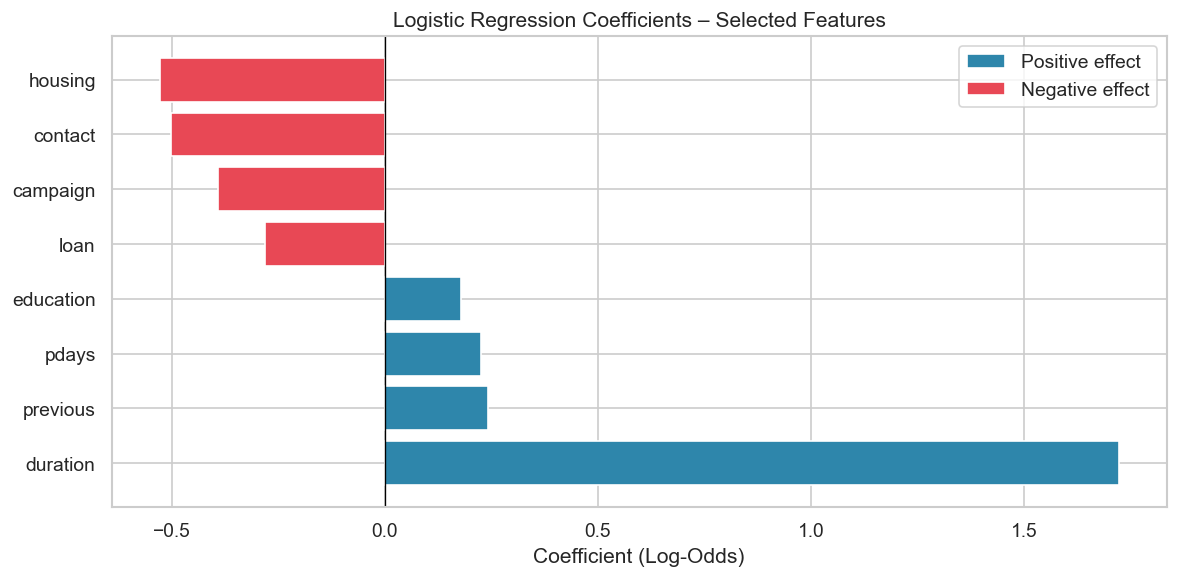

  feature  coefficient
 duration       1.7230
 previous       0.2416
    pdays       0.2262
education       0.1781
     loan      -0.2823
 campaign      -0.3920
  contact      -0.5031
  housing      -0.5294


In [14]:
coef_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient': baseline_model.coef_[0].round(4)
}).sort_values('coefficient', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
colors = [BLUE if c > 0 else RED for c in coef_df['coefficient']]
ax.barh(coef_df['feature'], coef_df['coefficient'], color=colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient (Log-Odds)')
ax.set_title('Logistic Regression Coefficients – Selected Features')
legend_elements = [
    Patch(facecolor=BLUE, label='Positive effect'),
    Patch(facecolor=RED, label='Negative effect')
]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

print(coef_df.to_string(index=False))

---
## 11. Week 4 Summary

In [15]:
print(f"""
Week 4 Summary
=============================================================
Model Selected       : Logistic Regression
Reason               : Binary target, interpretable, validated in literature

Feature Selection Methods:
  1. Point Biserial Correlation
  2. Chi-Square Test
  3. Recursive Feature Elimination (RFE)

Final Selected Features : {selected_features}

Hypotheses Developed : 4
Baseline Accuracy    : {acc*100:.2f}%

Next Steps (Week 5):
  - Full hypothesis testing using statistical tests
  - Model diagnostics (confusion matrix, ROC-AUC)
  - Validation and result interpretation
=============================================================
""")


Week 4 Summary
Model Selected       : Logistic Regression
Reason               : Binary target, interpretable, validated in literature

Feature Selection Methods:
  1. Point Biserial Correlation
  2. Chi-Square Test
  3. Recursive Feature Elimination (RFE)

Final Selected Features : ['education', 'loan', 'housing', 'previous', 'campaign', 'pdays', 'duration', 'contact']

Hypotheses Developed : 4
Baseline Accuracy    : 79.22%

Next Steps (Week 5):
  - Full hypothesis testing using statistical tests
  - Model diagnostics (confusion matrix, ROC-AUC)
  - Validation and result interpretation

